In [4]:
import numpy as np
from scipy.stats import pearsonr
from ElectionForecasting.src.root import ROOT_DIR
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
from statsmodels.stats.correlation_tools import corr_nearest
from statsmodels.stats.correlation_tools import cov_nearest
from scipy.linalg import cholesky
from scipy.linalg import sqrtm
from ElectionForecasting.src.config import party_order, province_order
from scipy.stats import pearsonr
from ElectionForecasting.src.data.processing.process_partisan_leans import load_election_results
# Load the demographic data
demographics_df = pd.read_csv(f'{ROOT_DIR}/data/dataland/dataland_demographics.csv')
demographics_df = demographics_df.set_index('province').loc[province_order].reset_index()
# Load the election results data
election_results_df = pd.read_csv(f'{ROOT_DIR}/data/dataland/dataland_election_results_1984_2023.csv')


In [5]:
election_results = load_election_results(f'{ROOT_DIR}/data/interim/state_results/')
pleans = [(year, df.sub(df.mean(axis=0), axis=1)) for year, df in election_results]
pleans[-1]

('2023',
                       cc_share  dgm_share  pdal_share  ssp_share
 province                                                        
 Amperville           -0.220592  -0.054738    0.368786  -0.093456
 Binaryshire           0.598455  -0.265259   -0.239740  -0.093456
 Byteforge Domain      0.138968  -0.167594    0.122082  -0.093456
 Cerebrica             0.022379   0.014947   -0.041891   0.004565
 Circuiton            -0.189738   0.238555    0.044639  -0.093456
 Cortexia             -0.132550  -0.057138   -0.060672   0.250360
 Electropolis          0.018113   0.098727   -0.023385  -0.093456
 Infinitron Peninsula  0.156639   0.049384   -0.112568  -0.093456
 Infoglen              0.088055   0.036830   -0.031429  -0.093456
 Neuronia             -0.233248  -0.090101   -0.262828   0.586177
 Quantumridge         -0.089036   0.058610    0.123881  -0.093456
 Voltagea             -0.157446   0.137776    0.113126  -0.093456)

In [6]:
# Try running the code again to calculate the provincial deviations from the national vote in each year
parties = ['cc_share', 'dgm_share', 'pdal_share', 'ssp_share']
# Filter out the relevant columns for vote shares
vote_shares_df = election_results_df[['year', 'province', 'cc_share', 'dgm_share', 'pdal_share', 'ssp_share']]

# Calculate the national vote as the mean of the election results in each province for each year, replacing NaNs with 0
national_vote_df  = vote_shares_df.fillna(0).groupby('year').agg({p: 'mean' for p in parties})

# Merge the national vote back into the original DataFrame to facilitate the calculation of deviations
merged_df = pd.merge(vote_shares_df, national_vote_df, on='year', suffixes=('', '_national'))

# Calculate how much each province deviated from the national vote in each year
for col in parties:
    merged_df[f'{col}'] = merged_df[col] - merged_df[f'{col}_national']
    merged_df.drop(columns=f'{col}_national', inplace=True)
# Filter to keep only the deviation columns
pleans_df = merged_df#[['year', 'province', 'cc_share_deviation', 'dgm_share_deviation', 'pdal_share_deviation', 'ssp_share_deviation']]
pleans_df

year              province  cc_share  dgm_share  pdal_share  ssp_share
0    1984            Amperville -0.223489  -0.064105    0.394374  -0.106779
1    1984           Binaryshire  0.558151  -0.223439   -0.227933  -0.106779
2    1984      Byteforge Domain  0.166943  -0.163688    0.103524  -0.106779
3    1984             Cerebrica  0.037204   0.028413   -0.055650  -0.009967
4    1984             Circuiton -0.197471   0.234998    0.069252  -0.106779
..    ...                   ...       ...        ...         ...        ...
475  2023  Infinitron Peninsula  0.156639   0.049384   -0.112568  -0.093456
476  2023              Infoglen  0.088055   0.036830   -0.031429  -0.093456
477  2023              Neuronia -0.233248  -0.090101   -0.262828   0.586177
478  2023          Quantumridge -0.089036   0.058610    0.123881  -0.093456
479  2023              Voltagea -0.157446   0.137776    0.113126  -0.093456

[480 rows x 6 columns]

In [7]:
# Function to calculate the correlation and p-value
def calculate_correlation_and_pvalue(df, column1, column2):
    corr, p_value = pearsonr(df[column1], df[column2])
    return corr if p_value < 0.05 else 0

# Convert the multi-index to a single concatenated index
def concatenate_multi_index(multi_index):
    return [f"{state}_{party}" for state, party in multi_index]

def plot_heatmap(df, title='Pairwise Correlations Across All States and Parties'):
    # Plot the large correlation matrix as a heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.fillna(0), annot=False, cmap='coolwarm', cbar=True, square=True)
    plt.title(title)
    plt.show()

# Define a function to integrate the cross-sectional correlation into the province-specific correlation matrices
def integrate_cross_sectional_correlation(province_corr, cross_sectional_corr):
    # Find common parties between the two matrices
    common_parties = list(set(province_corr.columns).intersection(set(cross_sectional_corr.index)))
    
    # Extract the sub-matrices corresponding to the common parties
    province_sub_matrix = province_corr.loc[common_parties, common_parties]
    
    # Integrate the two matrices. Here, we'll replace the diagonal with the values from cross_sectional_corr
    for party in common_parties:
        for demographic in cross_sectional_corr.columns:
            if province_corr.columns.isin([demographic]).any():
                province_corr.loc[party, demographic] = cross_sectional_corr.loc[party, demographic]
                province_corr.loc[demographic, party] = cross_sectional_corr.loc[party, demographic]
                
    return province_corr

# Function to calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Function to make sure the matrix is real after making it PSD
def ensure_real(matrix):
    return np.real(matrix)


In [8]:

# # Filter out the relevant columns for vote shares
vote_shares_df = election_results_df[['year', 'province', 'cc_share', 'dgm_share', 'pdal_share', 'ssp_share']]
# # List of parties to consider for correlation
parties = [p+'_share' for p in party_order]
relevant_demographics = ['population', 'python_pop_share', 'cobolite_pop_share', 'javarian_pop_share']
average_vote_shares_df = vote_shares_df.groupby('province')[parties].mean().reset_index()
demographics_filtered_df = demographics_df[['province'] + relevant_demographics]
merged_df = pd.merge(average_vote_shares_df, demographics_filtered_df, on='province', how='inner')
example_provinces = ['Amperville', 'Cerebrica']
# Initialize a DataFrame to store significant cross-sectional correlations
significant_cross_sectional_correlation = pd.DataFrame(index=parties, columns=relevant_demographics)

# Calculate significant cross-sectional correlations
for party in parties:
    for feature in relevant_demographics:
        significant_cross_sectional_correlation.at[party, feature] = calculate_correlation_and_pvalue(merged_df, party, feature)

significant_cross_sectional_correlation
# Define a function to integrate the cross-sectional correlation into the province-specific correlation matrices
def integrate_cross_sectional_correlation(province_corr, cross_sectional_corr):
    # Find common parties between the two matrices
    common_parties = list(set(province_corr.columns).intersection(set(cross_sectional_corr.index)))
    
    # Extract the sub-matrices corresponding to the common parties
    province_sub_matrix = province_corr.loc[common_parties, common_parties]
    
    # Integrate the two matrices. Here, we'll replace the diagonal with the values from cross_sectional_corr
    for party in common_parties:
        for demographic in cross_sectional_corr.columns:
            if province_corr.columns.isin([demographic]).any():
                province_corr.loc[party, demographic] = cross_sectional_corr.loc[party, demographic]
                province_corr.loc[demographic, party] = cross_sectional_corr.loc[party, demographic]
                
    return province_corr
significant_cross_sectional_correlation

population python_pop_share cobolite_pop_share javarian_pop_share
cc_share            0        -0.797088           0.932345                  0
dgm_share           0                0                  0           0.619615
pdal_share          0                0                  0                  0
ssp_share           0                0                  0                  0

In [9]:
demographics_filtered_df

province  population  python_pop_share  cobolite_pop_share  \
0              Cerebrica      850000          0.404046            0.529105   
1               Cortexia     1400000          0.592846            0.170363   
2               Neuronia      250000          0.676468            0.100817   
3             Amperville     1000000          0.765173            0.084048   
4            Binaryshire      150000          0.030380            0.927361   
5       Byteforge Domain      650000          0.545108            0.317107   
6              Circuiton      500000          0.402774            0.059544   
7           Electropolis     2250000          0.265686            0.229266   
8   Infinitron Peninsula      200000          0.167412            0.439659   
9               Infoglen     1750000          0.134158            0.295264   
10          Quantumridge      250000          0.530973            0.199361   
11              Voltagea      750000          0.736797            0.123078   

    javarian_pop_share  
0             0.066849  
1             0.236791  
2             0.222715  
3             0.150780  
4             0.042259  
5             0.137786  
6             0.537682  
7             0.505048  
8             0.392929  
9             0.570578  
10            0.269666  
11            0.140124

In [10]:
# Reshape the deviation_df to make it suitable for calculating the correlation matrix
reshaped_deviation_df = pleans_df.melt(id_vars=['year', 'province'], var_name='party', value_name='deviation')

# Create a composite column that combines province and party
reshaped_deviation_df['province_party'] = reshaped_deviation_df['province'] + "_" + reshaped_deviation_df['party']

# Pivot the table to get a DataFrame suitable for calculating correlations
pivot_deviation_df = reshaped_deviation_df.pivot(index='year', columns='province_party', values='deviation')

In [11]:
# integrate_cross_sectional_correlation(significant_province_correlation_matrices['Amperville'], 
#                                                                      significant_cross_sectional_correlation)

/home/ae_linux/Projects/ElectionForecasting/.venv/lib/python3.10/site-packages/statsmodels/stats/correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


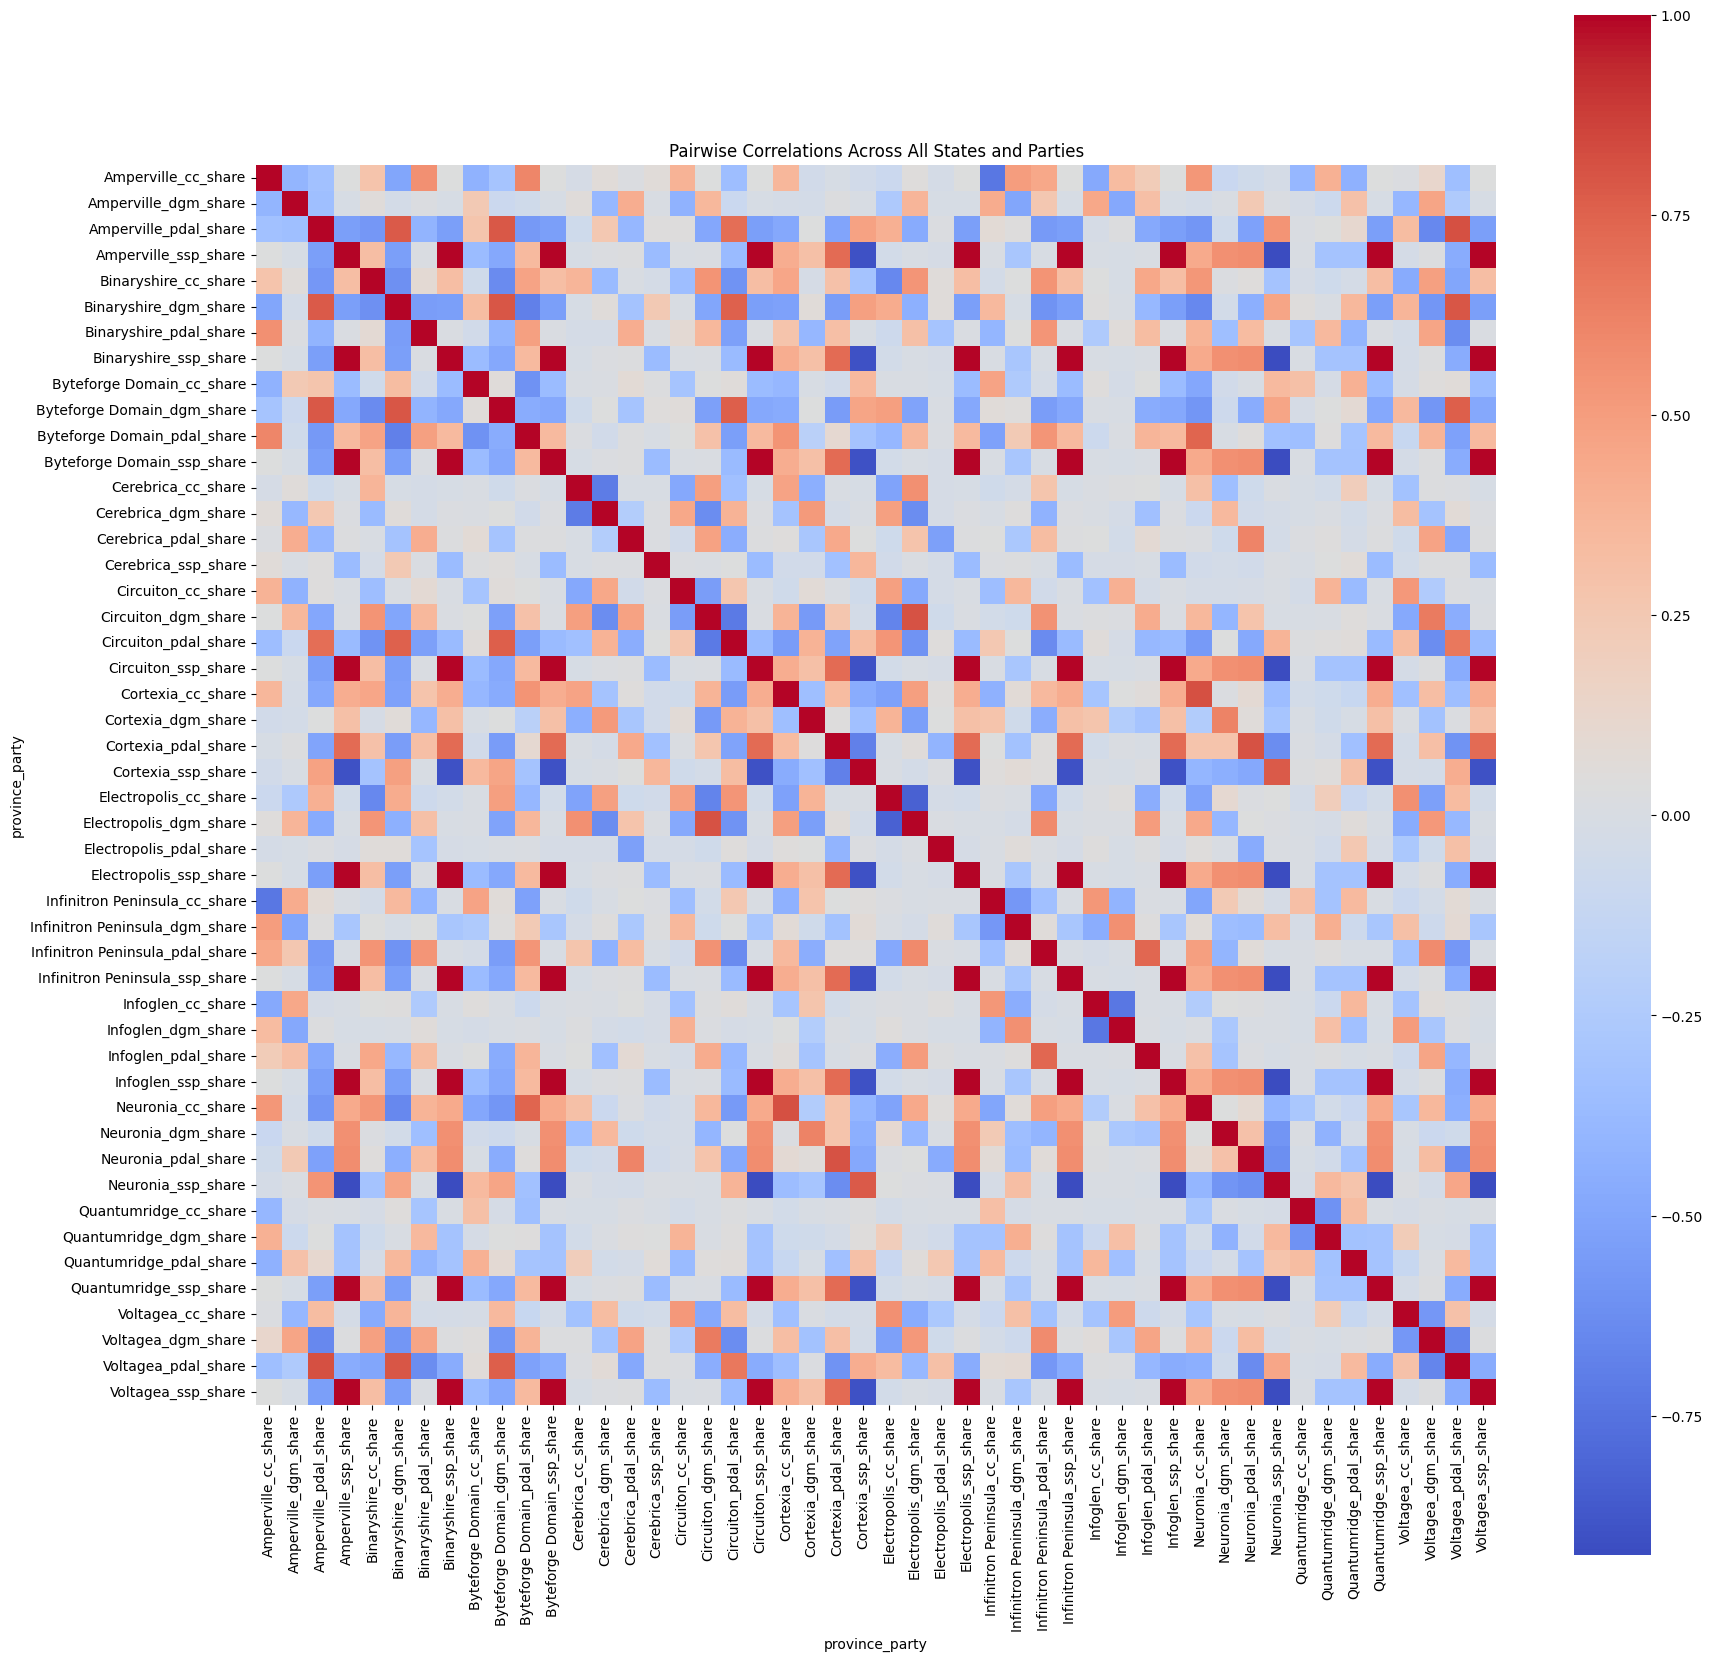

In [12]:
def fix_cov(cov):
    # Compute the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)
    # Take the real parts of the eigenvalues and eigenvectors
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)

    # Replace negative eigenvalues with small positive values (e.g., 1e-8)
    eigvals[eigvals < 0] = 1e-8

    # Reconstruct the matrix
    reconstructed_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Ensure the diagonal is exactly 1.0 for a correlation matrix
    np.fill_diagonal(reconstructed_matrix, 1.0)
    # Make sure the matrix is real
    reconstructed_matrix = np.real(reconstructed_matrix)
    return reconstructed_matrix

# Eigenvalue correction method
def eigenvalue_correction(corr_matrix):
    eigvals, eigvecs = np.linalg.eig(corr_matrix)
    eigvals[eigvals < 0] = 0
    corrected_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return ensure_real(corrected_matrix)

# Higham's method
def higham_method(corr_matrix, max_iter=100, tol=1e-6):
    Y = corr_matrix.copy()
    for _ in range(max_iter):
        eigvals, eigvecs = np.linalg.eig(Y)
        Q = eigvecs @ np.diag(np.maximum(eigvals, 0)) @ eigvecs.T
        Y = (Y + Q) / 2
        if np.linalg.norm(Y - Q, 'fro') < tol:
            break
    return ensure_real(Y)


def nearest_covariance(df):
    nearest_cov_matrix = cov_nearest(df)
    # Normalize to get the correlation matrix
    variances = np.diag(nearest_cov_matrix)
    diag_matrix_inv_sqrt = np.diag(1 / np.sqrt(variances))
    nearest_corr_matrix = diag_matrix_inv_sqrt @ nearest_cov_matrix @ diag_matrix_inv_sqrt
    np.fill_diagonal(nearest_corr_matrix, 1.0)
    nearest_is_positive_semi_definite = np.all(np.linalg.eigvals(nearest_corr_matrix) >= -1e-8)
    assert nearest_is_positive_semi_definite
    distance = frobenius_norm(df, nearest_corr_matrix)
    return nearest_corr_matrix

# Define a function to compute correlation and p-value, and filter based on significance level
def filter_significant_corr(df, alpha=0.05):
    cov_matrix = df.cov()
    corr_matrix = df.corr()
    p_values_matrix = corr_matrix.copy()
    
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            if col1 == col2:
                p_values_matrix.loc[col1, col2] = 0  # Same variable; p-value is irrelevant
            else:
                non_na_indices = df[[col1, col2]].dropna().index
                x = df.loc[non_na_indices, col1]
                y = df.loc[non_na_indices, col2]
                if len(x) > 1:  # Need at least two non-NA observations to perform the test
                    _, p_value = pearsonr(x, y)
                    p_values_matrix.loc[col1, col2] = p_value
                else:
                    p_values_matrix.loc[col1, col2] = 1  # Set to non-significant if not enough data
    
    # Filter based on significance level
    significant_corr_matrix = corr_matrix.where(p_values_matrix < alpha, np.nan)
    significant_cov_matrix = cov_matrix.where(p_values_matrix < alpha, np.nan)
    significant_corr_matrix.fillna(0, inplace=True)
    significant_cov_matrix.fillna(0, inplace=True)
    significant_cov_matrix_SPD = cov_nearest(significant_cov_matrix.values, method='clipped', threshold=1e-15, n_fact=100, return_all=False)
    significant_corr_matrix_SPD = corr_nearest(significant_corr_matrix.values, threshold=1e-10, n_fact=10000)
    significant_corr_matrix_SPD = nearest_covariance(significant_corr_matrix) #
    # print(np.any((significant_cov_matrix_SPD - significant_cov_matrix.values).round() > 0))
    significant_cov_matrix = pd.DataFrame(significant_cov_matrix_SPD, columns=significant_cov_matrix.columns, index=significant_cov_matrix.index)
    significant_corr_matrix = pd.DataFrame(significant_corr_matrix_SPD, columns=significant_corr_matrix.columns, index=significant_corr_matrix.index)
    return significant_corr_matrix, significant_cov_matrix, p_values_matrix

# Calculate and filter the correlation matrix in one step
significant_corr_matrix, significant_cov_matrix, p_values_matrix = filter_significant_corr(pivot_deviation_df)
plot_heatmap(significant_corr_matrix)

In [13]:
significant_cov_matrix.min().min()

-0.0018290523828715676

In [14]:

# Check if the matrix is square
is_square_new = significant_corr_matrix.shape[0] == significant_corr_matrix.shape[1]

# Check if the matrix is symmetric
is_symmetric_new = np.allclose(significant_corr_matrix, significant_corr_matrix.T, atol=1e-8)

# Check if the matrix is positive semi-definite
eigenvalues_new = np.linalg.eigvals(significant_corr_matrix)
is_positive_semi_definite_new = np.all(eigenvalues_new >= -1e-8)  # small numerical tolerance

# Check for NaN or infinite values in the matrix
has_nan = np.any(np.isnan(significant_corr_matrix).any())
has_inf = np.any(np.isinf(significant_corr_matrix).any())

is_square_new, is_symmetric_new, is_positive_semi_definite_new, eigenvalues_new.min(), has_nan, has_inf

(True, True, True, (2.1935419797592643e-17+0j), False, False)

In [15]:
from scipy.linalg import cholesky
from statsmodels.stats.correlation_tools import cov_nearest
new_corr_matrix_values = significant_corr_matrix.copy()
# Function to calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Initialize dictionary to store results
results = {}

# 1. Eigenvalue Correction
eigvals, eigvecs = np.linalg.eig(new_corr_matrix_values)
eigvals[eigvals < 0] = 1e-8
eigen_corrected_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
np.fill_diagonal(eigen_corrected_matrix, 1.0)
eigen_is_positive_semi_definite = np.all(np.linalg.eigvals(eigen_corrected_matrix) >= -1e-8)
results['Eigenvalue Correction'] = {
    'is_positive_semi_definite': eigen_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, eigen_corrected_matrix)
}

# 2. Higham's Method
higham_matrix = new_corr_matrix_values.copy()
for _ in range(100):  # Max 100 iterations
    eigvals, eigvecs = np.linalg.eig(higham_matrix)
    eigvals[eigvals < 0] = 0
    higham_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    higham_matrix = 0.5 * (higham_matrix + higham_matrix.T)
    np.fill_diagonal(higham_matrix, 1.0)
higham_is_positive_semi_definite = np.all(np.linalg.eigvals(higham_matrix) >= -1e-8)
results['Higham'] = {
    'is_positive_semi_definite': higham_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, higham_matrix)
}

# # 3. Adding a multiple of the identity matrix
# identity_added_matrix = new_corr_matrix_values.copy()
# smallest_eigval = np.min(np.linalg.eigvals(identity_added_matrix))
# i = 1e-8
# while smallest_eigval < 0:
#     identity_added_matrix = new_corr_matrix_values + i * np.identity(new_corr_matrix_values.shape[0])
#     smallest_eigval = np.min(np.linalg.eigvals(identity_added_matrix))
#     i += 1e-8
# identity_is_positive_semi_definite = np.all(np.linalg.eigvals(identity_added_matrix) >= -1e-8)
# results['Identity Addition'] = {
#     'is_positive_semi_definite': identity_is_positive_semi_definite,
#     'change': frobenius_norm(new_corr_matrix_values, identity_added_matrix)
# }

# 4. Nearest Covariance Matrix (cov_nearest)
nearest_cov_matrix = cov_nearest(new_corr_matrix_values)
# Normalize to get the correlation matrix
variances = np.diag(nearest_cov_matrix)
diag_matrix_inv_sqrt = np.diag(1 / np.sqrt(variances))
nearest_corr_matrix = diag_matrix_inv_sqrt @ nearest_cov_matrix @ diag_matrix_inv_sqrt
np.fill_diagonal(nearest_corr_matrix, 1.0)
nearest_is_positive_semi_definite = np.all(np.linalg.eigvals(nearest_corr_matrix) >= -1e-8)
results['Nearest Covariance'] = {
    'is_positive_semi_definite': nearest_is_positive_semi_definite,
    'change': frobenius_norm(new_corr_matrix_values, nearest_corr_matrix)
}


In [16]:
results

{'Eigenvalue Correction': {'is_positive_semi_definite': True,
  'change': 4.080318014864775e-14},
 'Higham': {'is_positive_semi_definite': True,
  'change': 6.0569699437686746e-05},
 'Nearest Covariance': {'is_positive_semi_definite': True,
  'change': 2.4668895651116404e-14}}

In [17]:
# Function to calculate the correlation matrix with p-value filtering
def calculate_filtered_corr_matrix(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1  # Same variable; correlation is 1
            else:
                non_na_indices = df[[col1, col2]].dropna().index
                x = df.loc[non_na_indices, col1]
                y = df.loc[non_na_indices, col2]
                if len(x) > 1:  # Need at least two non-NA observations to perform the test
                    corr, p_value = pearsonr(x, y)
                    corr_matrix.loc[col1, col2] = corr if p_value < 0.05 else 0
                else:
                    corr_matrix.loc[col1, col2] = 0  # Set to 0 if not enough data
    return corr_matrix.astype(float)

# Calculate the filtered correlation matrix
filtered_corr_matrix = calculate_filtered_corr_matrix(pivot_deviation_df)

results_real = {}
# Apply methods and calculate Frobenius norm for the change in each case
methods = {'Eigenvalue Correction': eigenvalue_correction,
           'Higham\'s Method': higham_method,
           'Nearest Covariance': nearest_covariance}

for method, func in methods.items():
    try:
        transformed_matrix = func(filtered_corr_matrix.values)
        is_positive_semi_definite = np.all(np.linalg.eigvals(transformed_matrix) >= -1e-8)
        frobenius_change = frobenius_norm(filtered_corr_matrix.values, transformed_matrix)
        results_real[method] = {
            'is_positive_semi_definite': is_positive_semi_definite,
            'frobenius_change': frobenius_change
        }
    except Exception as e:
        results_real[method] = {'error': str(e)}

results_real

{'Eigenvalue Correction': {'is_positive_semi_definite': True,
  'frobenius_change': 2.2909670375104136},
 "Higham's Method": {'is_positive_semi_definite': False,
  'frobenius_change': 2.290966491301308},
 'Nearest Covariance': {'is_positive_semi_definite': True,
  'frobenius_change': 3.546005101971887}}

In [18]:
# cov_filled = pd.DataFrame(eigenvalue_correction(filtered_corr_matrix.values), columns=filtered_corr_matrix.columns, index=filtered_corr_matrix.index)
# plot_heatmap(cov_filled)
# significant_corr_matrix = cov_filled.copy()


In [19]:
significant_corr_matrix

province_party                   Amperville_cc_share  Amperville_dgm_share  \
province_party                                                               
Amperville_cc_share                         1.000000             -0.406283   
Amperville_dgm_share                       -0.406283              1.000000   
Amperville_pdal_share                      -0.328204             -0.340695   
Amperville_ssp_share                        0.036520             -0.009739   
Binaryshire_cc_share                        0.280650              0.054672   
Binaryshire_dgm_share                      -0.501945             -0.030666   
Binaryshire_pdal_share                      0.556653              0.018041   
Binaryshire_ssp_share                       0.036520             -0.009739   
Byteforge Domain_cc_share                  -0.424690              0.247107   
Byteforge Domain_dgm_share                 -0.304824             -0.085360   
Byteforge Domain_pdal_share                 0.606099             -0.059020   
Byteforge Domain_ssp_share                  0.036520             -0.009739   
Cerebrica_cc_share                         -0.016910              0.058697   
Cerebrica_dgm_share                         0.063376             -0.387330   
Cerebrica_pdal_share                        0.017467              0.416080   
Cerebrica_ssp_share                         0.061535              0.001417   
Circuiton_cc_share                          0.391076             -0.421928   
Circuiton_dgm_share                         0.037627              0.360621   
Circuiton_pdal_share                       -0.348782             -0.089815   
Circuiton_ssp_share                         0.036520             -0.009739   
Cortexia_cc_share                           0.365823             -0.028390   
Cortexia_dgm_share                         -0.049693             -0.036446   
Cortexia_pdal_share                        -0.009335              0.029041   
Cortexia_ssp_share                         -0.045705              0.000388   
Electropolis_cc_share                      -0.089025             -0.262109   
Electropolis_dgm_share                      0.051606              0.370261   
Electropolis_pdal_share                    -0.023638             -0.013517   
Electropolis_ssp_share                      0.036520             -0.009739   
Infinitron Peninsula_cc_share              -0.730994              0.422012   
Infinitron Peninsula_dgm_share              0.497650             -0.502522   
Infinitron Peninsula_pdal_share             0.450521              0.262873   
Infinitron Peninsula_ssp_share              0.036520             -0.009739   
Infoglen_cc_share                          -0.474571              0.447511   
Infoglen_dgm_share                          0.334046             -0.481494   
Infoglen_pdal_share                         0.221289              0.309320   
Infoglen_ssp_share                          0.036520             -0.009739   
Neuronia_cc_share                           0.531182             -0.032094   
Neuronia_dgm_share                         -0.102407              0.005677   
Neuronia_pdal_share                        -0.058873              0.247927   
Neuronia_ssp_share                         -0.027265              0.010239   
Quantumridge_cc_share                      -0.391785             -0.021382   
Quantumridge_dgm_share                      0.395697             -0.074932   
Quantumridge_pdal_share                    -0.429139              0.299929   
Quantumridge_ssp_share                      0.036520             -0.009739   
Voltagea_cc_share                           0.022982             -0.396768   
Voltagea_dgm_share                          0.126193              0.462528   
Voltagea_pdal_share                        -0.344316             -0.253385   
Voltagea_ssp_share                          0.036520             -0.009739   

province_party                   Amperville_pdal_share  Amperville_ssp_share  \
province_party     

In [20]:

# # Save significant province correlation matrices
# with open(f'{ROOT_DIR}/data/interim/correlations/significant_province_correlation_matrices.pkl', 'wb') as f:
#     pickle.dump(significant_province_correlation_matrices, f)

# # Save significant cross-sectional correlations
# with open(f'{ROOT_DIR}/data/interim/correlations/significant_cross_sectional_correlation.pkl', 'wb') as f:
#     pickle.dump(significant_cross_sectional_correlation, f)

In [21]:

# Modify the function to make the figure square and adjust the orientation of the diagonal
def plot_significant_correlations_square(corr_matrix, p_values_matrix):
    """
    Plots a heatmap of the correlation matrix without annotations, overlaying p-values where appropriate
    on hover. Only shows significant correlations (based on the p_values_matrix). The figure is square
    and the diagonal runs from top-left to bottom-right.
    
    Parameters:
    - corr_matrix: DataFrame containing correlations
    - p_values_matrix: DataFrame containing p-values
    
    Returns: Plotly Figure
    """
    
    # Convert DataFrames to numpy for easier element-wise operations
    corr_values = corr_matrix.to_numpy()
    p_values = p_values_matrix.to_numpy()
    
    # Create hovertext matrix: show correlation and p-value for each cell
    hovertext = []
    for i in range(corr_values.shape[0]):
        hovertext_row = []
        for j in range(corr_values.shape[1]):
            text = f"{corr_matrix.columns[i].replace('_', ' ').replace(' share', '')} - {corr_matrix.index[j].replace('_', ' ').replace(' share', '')}<br>Correlation: {corr_values[i, j]:.4f}<br>P-Value: {p_values[i, j]:.4f}"
            hovertext_row.append(text)
        hovertext.append(hovertext_row)

    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
                    z=np.flipud(corr_values),  # Flip the matrix upside down for correct orientation
                    x=corr_matrix.columns.str.replace('_', ' ').str.replace(' share', ''),
                    y=corr_matrix.index[::-1].str.replace('_', ' ').str.replace(' share', ''),  # Invert for correct orientation
                    hoverinfo='text',
                    text=np.flipud(hovertext),  # Flip the hovertext as well
                    reversescale=True,
                    colorscale='RdBu')) # Agsunset
    
    # Add titles and labels
    fig.update_layout(
        title='Pairwise Correlation Matrix with P-Values',
        xaxis=dict(title='Party & State', tickfont=dict(size=7)),
        yaxis=dict(title='Party & State', tickfont=dict(size=7)),
        autosize=False,
        width=800,
        height=800  # Square figure
    )
    
    return fig

# Create the plot with hover text only, formatted axis labels, and square figure
fig_square = plot_significant_correlations_square(significant_corr_matrix, p_values_matrix)
fig_square.show()


In [22]:
significant_corr_matrix.to_csv(f'{ROOT_DIR}/data/interim/correlations/significant_province_correlation_matrices.csv')
significant_cov_matrix.to_csv(f'{ROOT_DIR}/data/interim/correlations/significant_province_covariance_matrices.csv')

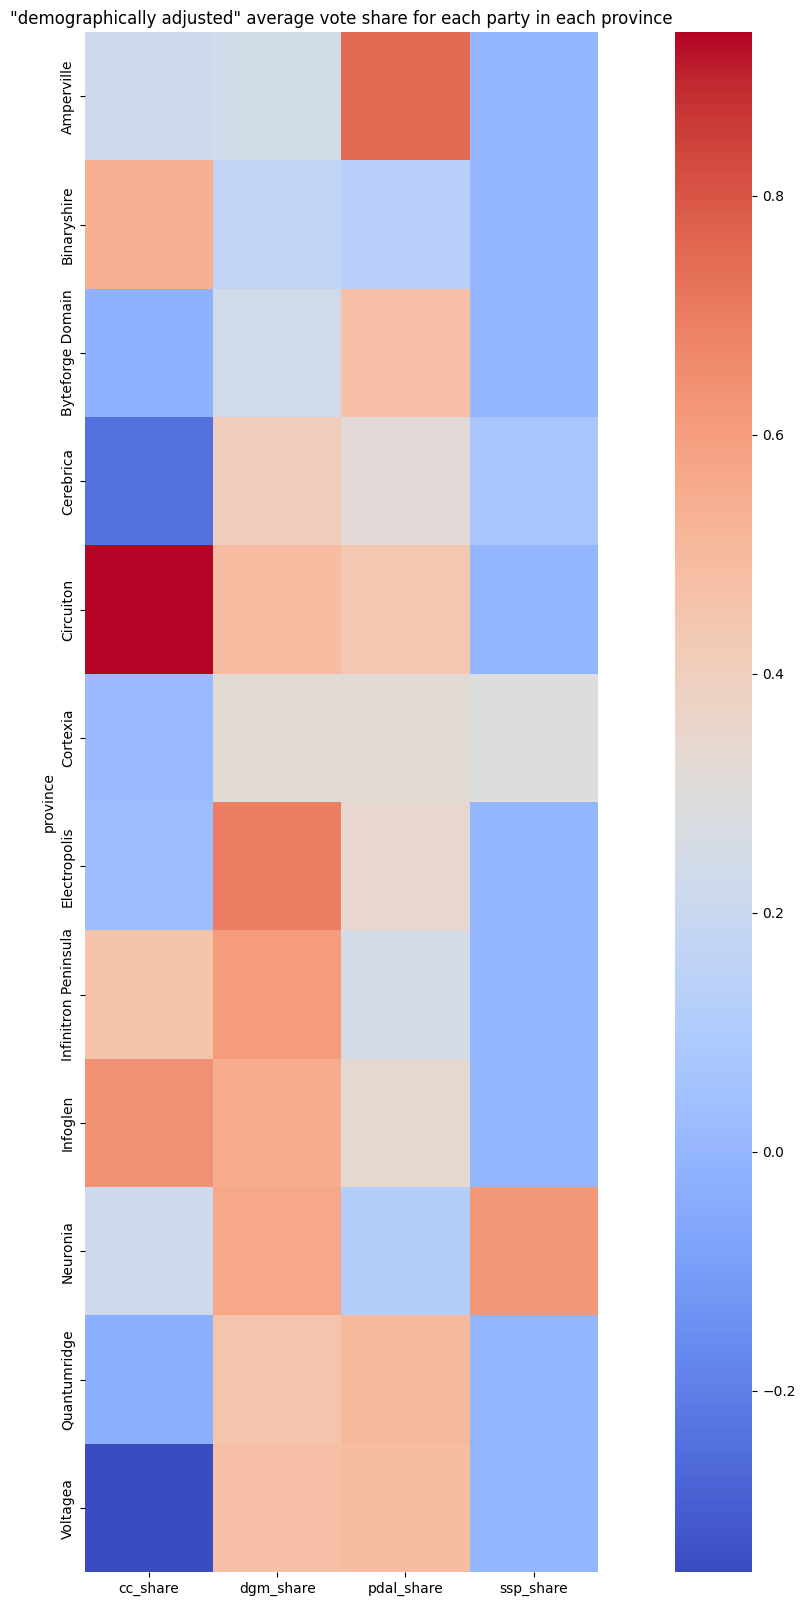

In [23]:
# For each province, multiply the significant cross-sectional correlations by the corresponding demographic values
weighted_demographics_df = demographics_filtered_df.copy()
for party in parties:
    for feature in relevant_demographics:
        correlation = significant_cross_sectional_correlation.at[party, feature]
        if not np.isnan(correlation):
            weighted_feature_name = f"{party}_weighted_by_{feature}"
            weighted_demographics_df[weighted_feature_name] = demographics_filtered_df[feature] * correlation

# Sum the weighted values to get a "demographically adjusted" average vote share for each party in each province
adjusted_vote_shares_df = average_vote_shares_df.copy()
for party in parties:
    weighted_features_for_party = [col for col in weighted_demographics_df.columns if col.startswith(f"{party}_weighted_by_")]
    adjusted_vote_shares_df[party] = average_vote_shares_df[party] + weighted_demographics_df[weighted_features_for_party].sum(axis=1)
adjusted_vote_shares_df.replace(0, np.nan, inplace=True)
plot_heatmap(adjusted_vote_shares_df.set_index('province'), title='"demographically adjusted" average vote share for each party in each province')

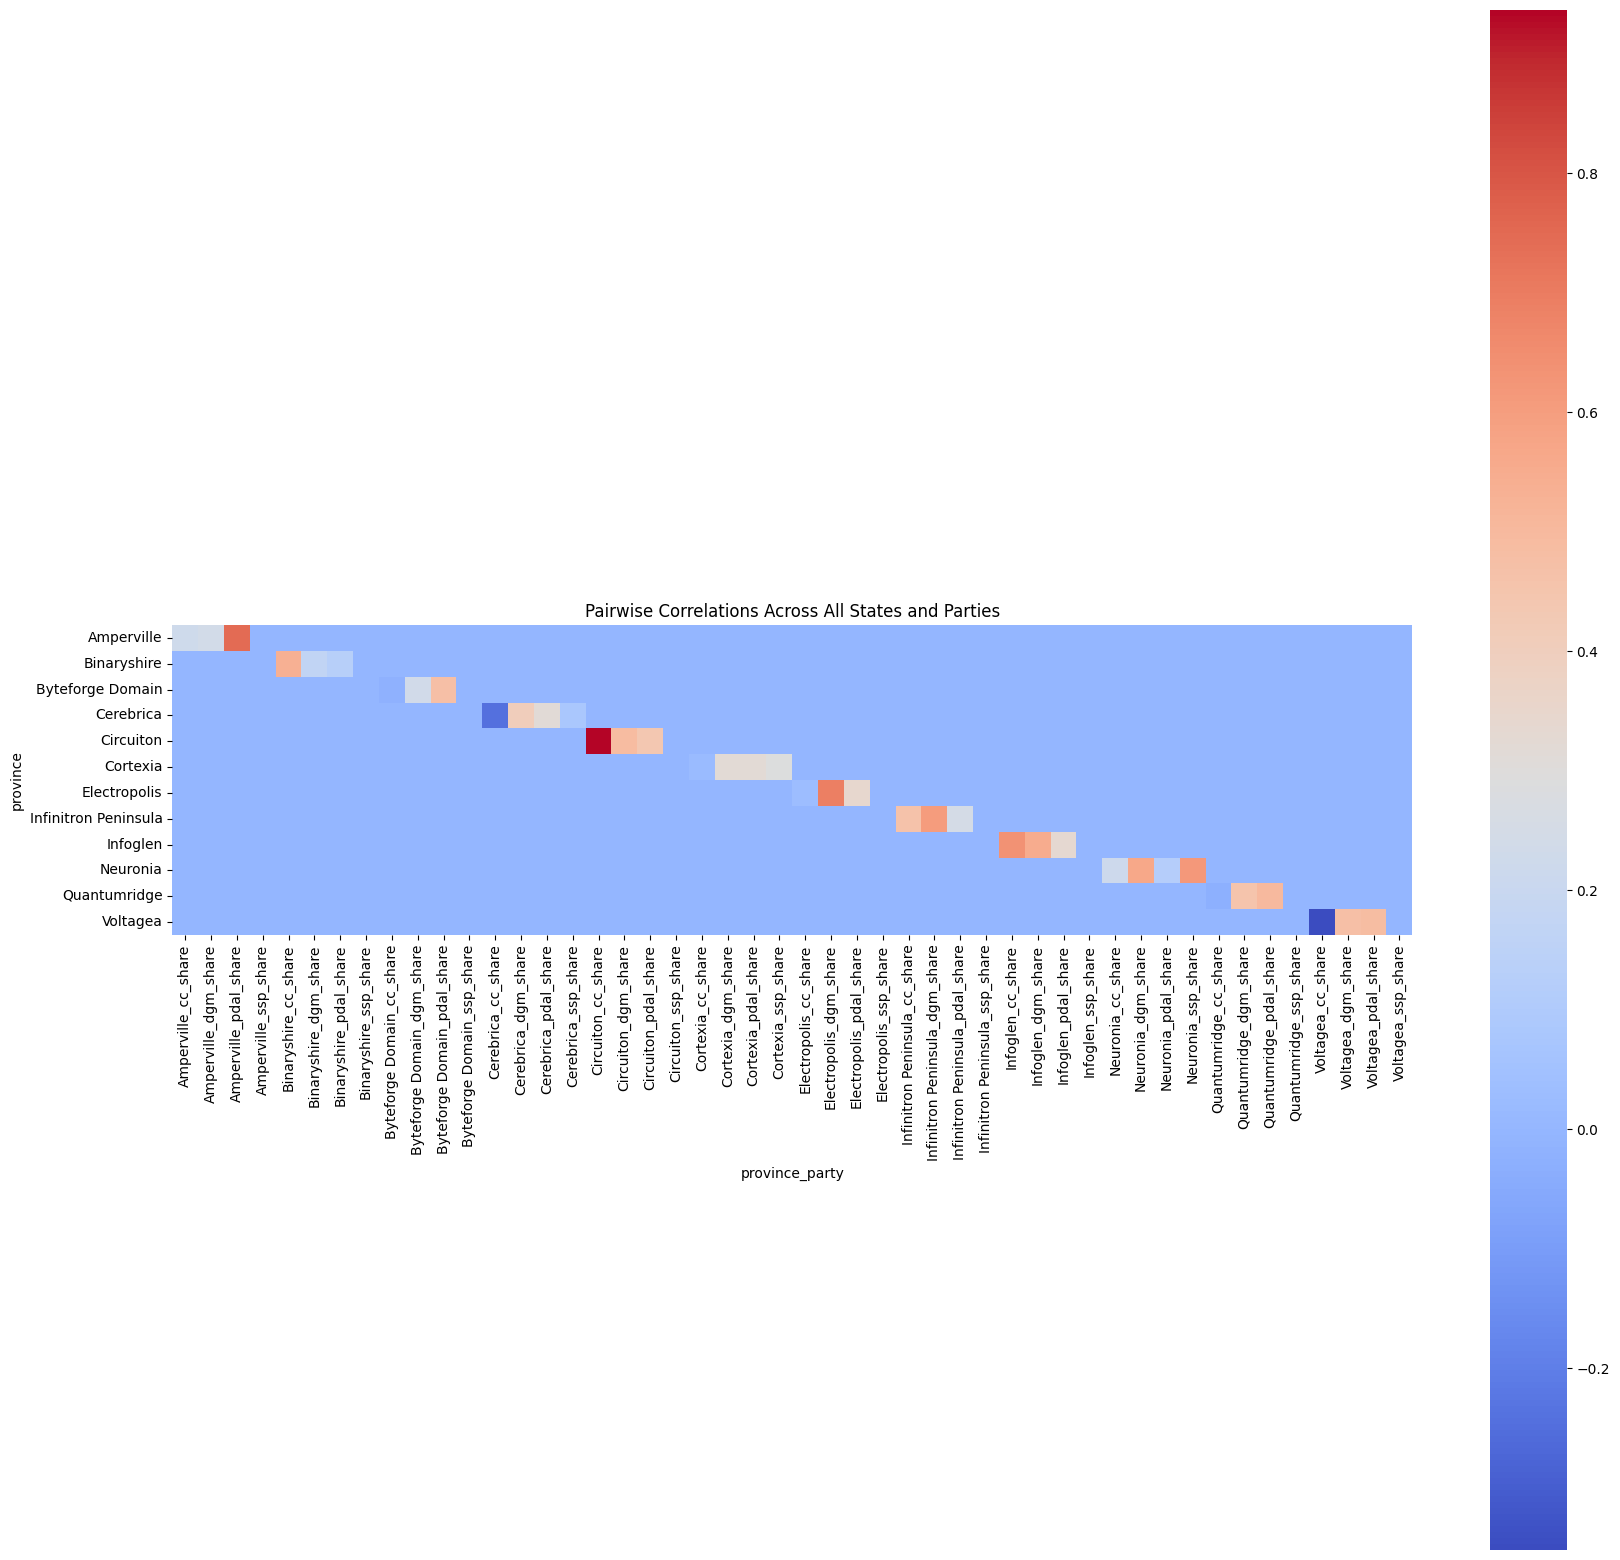

In [24]:
# Reshape the deviation_df to make it suitable for calculating the correlation matrix
reshaped_adjusted_vote_shares_df = adjusted_vote_shares_df.melt(id_vars=['province'], var_name='party', value_name='adjusted')
# # Create a composite column that combines province and party
reshaped_adjusted_vote_shares_df['province_party'] = reshaped_adjusted_vote_shares_df['province'] + "_" + reshaped_adjusted_vote_shares_df['party']

# # Pivot the table to get a DataFrame suitable for calculating correlations
pivot_adjusted_vote_shares_df = reshaped_adjusted_vote_shares_df.pivot(index='province', columns='province_party', values='adjusted')
pivot_adjusted_vote_shares_df.replace(0, np.nan, inplace=True)
plot_heatmap(pivot_adjusted_vote_shares_df)